In [40]:
using CairoMakie, SparseArrays, LDPCDecoders
using QuantumClifford: Stabilizer, MixedDestabilizer, sHadamard, logicalxview, logicalzview, sMRZ, PauliError, pftrajectories, pfmeasurements, stab_to_gf2, PauliFrame, PauliError, AbstractOperation
using QuantumClifford.ECC: faults_matrix, naive_syndrome_circuit, parity_checks, AbstractECC, naive_encoding_circuit, Cleve8, Steane7, Shor9, Perfect5
include("./util/QECC_converter.jl")
using .QECC_Converter
using Quantikz
using QuantumClifford
import QuantumClifford.ECC:parity_checks

In [2]:
function fault_tolerant_encoding(scirc)
    ecirc = Vector{QuantumClifford.AbstractOperation}()
    for gate in scirc
        if isa(gate,sMRZ)
            push!(ecirc, sMZ(gate.qubit))
        elseif isa(gate,sMRX)
            push!(ecirc, sMX(gate.qubit))
        elseif isa(gate,sMRY)
            push!(ecirc, sMY(gate.qubit))
        else
            push!(ecirc, gate)
        end
    end
    return ecirc
end

fault_tolerant_encoding (generic function with 1 method)

In [3]:
function evaluate_code_decoder_FTecirc_pf_krishna(Cx, Cz, checks, scirc, p_init, p_shift=0 ; nframes=1_000, encoding_locs=nothing, max_iters = 25)
    O = faults_matrix(checks)
    circuit_Z = Base.copy(scirc)
    circuit_X = Base.copy(scirc)
    println(circuit_Z)
    println(circuit_X)

    @assert size(Cx, 2) == size(Cz, 2) == nqubits(checks)
    @assert size(Cx, 1) + size(Cz, 1) == length(checks)

    s, n = size(checks)
    _, _, r = canonicalize!(Base.copy(checks), ranks=true)
    k = n - r

    # Krishna decoder
    log_probabs = zeros(n)
    channel_probs = fill(p_init, n)

    numchecks_X = size(Cx)[1]
    b2c_X = zeros(numchecks_X, n)
    c2b_X = zeros(numchecks_X, n)

    numchecks_Z = size(Cz)[1]
    b2c_Z = zeros(numchecks_Z, n)
    c2b_Z = zeros(numchecks_Z, n)
    err = zeros(n)
    # end krishna
    
    if isnothing(encoding_locs)
        pre_X = [sHadamard(i) for i in n-k+1:n]
    else
        pre_X = [sHadamard(i) for i in encoding_locs]
    end

    md = MixedDestabilizer(checks)
    logview_Z = logicalzview(md)
    logcirc_Z, numLogBits_Z, _ = naive_syndrome_circuit(logview_Z)
    @assert numLogBits_Z == k

    logview_X = logicalxview(md)
    logcirc_X, numLogBits_X, _ = naive_syndrome_circuit(logview_X)
    @assert numLogBits_X == k

    # Z logic circuit
    for gate in logcirc_Z
        type = typeof(gate)
        if type == sMRZ
            push!(circuit_Z, sMRZ(gate.qubit+s, gate.bit+s))
        else
            push!(circuit_Z, type(gate.q1, gate.q2+s))
        end
    end

   # X logic circuit
    for gate in logcirc_X
        type = typeof(gate)
        if type == sMRZ
            push!(circuit_X, sMRZ(gate.qubit+s, gate.bit+s))
        else
            push!(circuit_X, type(gate.q1, gate.q2+s))
        end
    end

    errors = [PauliError(i,p_init) for i in 1:n]

    # Z simulation
    ecirc = fault_tolerant_encoding(circuit_Z)
    fullcircuit_Z = vcat(ecirc, errors, circuit_Z)

    frames = PauliFrame(nframes, n+s+k, s+k)
    pftrajectories(frames, fullcircuit_Z)
    syndromes = pfmeasurements(frames)[:, 1:s]
    logicalSyndromes = pfmeasurements(frames)[:, s+1: s+k]

    decoded = 0
    for i in 1:nframes
        row = syndromes[i,:]
        row_x = row[1:numchecks_X]
        row_z = row[numchecks_X+1:numchecks_X+numchecks_Z]

        KguessX, success = syndrome_decode(sparse(Cx), sparse(Cx'), row_x, max_iters, channel_probs, b2c_X, c2b_X, log_probabs, Base.copy(err))
        KguessZ, success = syndrome_decode(sparse(Cz), sparse(Cz'), row_z, max_iters, channel_probs, b2c_Z, c2b_Z, log_probabs, Base.copy(err))
        guess = vcat(KguessZ, KguessX)
        
        result_Z = (O * (guess))[k+1:2k]
        if result_Z == logicalSyndromes[i,:]
            decoded += 1
        end
    end
    z_error = 1 - decoded / nframes

    # X simulation
    ecirc = fault_tolerant_encoding(circuit_X)
    fullcircuit_X = vcat(pre_X, ecirc, errors, circuit_X)

    frames = PauliFrame(nframes, n+s+k, s+k)
    pftrajectories(frames, fullcircuit_X)
    syndromes = pfmeasurements(frames)[:, 1:s]
    logicalSyndromes = pfmeasurements(frames)[:, s+1: s+k]

    decoded = 0
    for i in 1:nframes
        row = syndromes[i,:]
        row_x = row[1:numchecks_X]
        row_z = row[numchecks_X+1:numchecks_X+numchecks_Z]

        KguessX, success = syndrome_decode(sparse(Cx), sparse(Cx'), row_x, max_iters, channel_probs, b2c_X, c2b_X, log_probabs, Base.copy(err))
        KguessZ, success = syndrome_decode(sparse(Cz), sparse(Cz'), row_z, max_iters, channel_probs, b2c_Z, c2b_Z, log_probabs, Base.copy(err))
        guess = vcat(KguessZ, KguessX)
        
        result_X = (O * (guess))[1:k]
        if result_X == logicalSyndromes[i, :]
            decoded += 1
        end
    end
    x_error = 1 - decoded / nframes

    return x_error, z_error
end

evaluate_code_decoder_FTecirc_pf_krishna (generic function with 2 methods)

In [4]:
function add_two_qubit_gate_noise(circuit, p_error)
    new_circuit = AbstractOperation[]
    for gate in circuit
        if isa(gate, QuantumClifford.AbstractTwoQubitOperator)
            push!(new_circuit, gate)
            push!(new_circuit, PauliError(gate.q1, p_error))
            push!(new_circuit, PauliError(gate.q2, p_error))
        else
            push!(new_circuit, gate)
        end
    end
    return new_circuit
end

add_two_qubit_gate_noise (generic function with 1 method)

In [5]:
CONFIG_PATH = string(@__DIR__, "/codelists/Steane-7.jl");
include(CONFIG_PATH);
tab = stabilizerStringToTableau(code["example"]["codestring"]);
stab = Stabilizer(tab);
(scirc, _), time1, _ = @timed naive_syndrome_circuit(stab);
ecirc, time2, _ = @timed naive_encoding_circuit(stab);
# println(stab_to_gf2(stab))
bool_tab = stab_to_gf2(stab)
n, m = size(bool_tab)
code_Cx = bool_tab[1:round(Int, n /2), 1:round(Int, m / 2)]
code_Cz = bool_tab[round(Int, n /2) + 1:end, round(Int, m / 2) + 1:end]
println(code_Cz)

Bool[0 0 0 1 1 1 1; 0 1 1 0 0 1 1; 1 0 1 0 1 0 1]


In [6]:
evaluate_code_decoder_FTecirc_pf_krishna(code_Cx, code_Cz, stab, scirc, 0.01, nframes = 100_000)

AbstractOperation[

QuantumClifford.sXCX(4,8), QuantumClifford.sXCX(5,8), QuantumClifford.sXCX(6,8), QuantumClifford.sXCX(7,8), sMRZ(8, 1), QuantumClifford.sXCX(2,9), QuantumClifford.sXCX(3,9), QuantumClifford.sXCX(6,9), QuantumClifford.sXCX(7,9), sMRZ(9, 2), QuantumClifford.sXCX(1,10), QuantumClifford.sXCX(3,10), QuantumClifford.sXCX(5,10), QuantumClifford.sXCX(7,10), sMRZ(10, 3), 

QuantumClifford.sCNOT(4,11), QuantumClifford.sCNOT(5,11), QuantumClifford.sCNOT(6,11), QuantumClifford.sCNOT(7,11), sMRZ(11, 4), QuantumClifford.sCNOT(2,12), QuantumClifford.sCNOT(3,12), QuantumClifford.sCNOT(6,12), QuantumClifford.sCNOT(7,12), sMRZ(12, 5), QuantumClifford.sCNOT(1,13), QuantumClifford.sCNOT(3,13), QuantumClifford.sCNOT(5,13), QuantumClifford.sCNOT(7,13), sMRZ(13, 6)]
AbstractOperation[QuantumClifford.sXCX(4,8), QuantumClifford.sXCX(5,8), QuantumClifford.sXCX(6,8), QuantumClifford.sXCX(7,8), sMRZ(8, 1), QuantumClifford.sXCX(2,9), QuantumClifford.sXCX(3,9), QuantumClifford.sXCX(6,9), QuantumClifford.sXCX(7,9), sMRZ(9, 2), QuantumClifford.sXCX(1,10), QuantumClifford.sXCX(3,10), QuantumClifford.sXCX(5,10), QuantumClifford.sXCX(7,10), sMRZ(10, 3), QuantumClifford.sCNOT(4,11), QuantumClifford.sCNOT(5,11), QuantumClifford.sCNOT(6,11), QuantumClifford.sCNOT(7,11), sMRZ(11, 4), QuantumClifford.sCNOT(2,12), QuantumClifford.sCNOT(3,12), QuantumClifford.sCNOT(6,12), QuantumCliffor

UndefVarError: UndefVarError: `nqubits` not defined

In [11]:
belief_decoder_eval_X(stab, ecirc, scirc, 0.01, nframes = 1)

UndefVarError: UndefVarError: `belief_decoder_eval_X` not defined

In [19]:
circuit_Z, _ = naive_syndrome_circuit(stab);
# println(typeof(circuit_Z))
# circuit_Z = add_two_qubit_gate_noise(circuit_Z, 0.09);
println(circuit_Z)

AbstractOperation[sXCX(4,8), sXCX(5,8), sXCX(6,8)

, sXCX(7,8), sMRZ(8, 1), sXCX(2,9), sXCX(3,9), sXCX(6,9), sXCX(7,9), sMRZ(9, 2), sXCX(1,10), sXCX(3,10), sXCX(5,10), sXCX(7,10), sMRZ(10, 3), sCNOT(4,11), sCNOT(5,11), sCNOT(6,11), sCNOT(7,11), sMRZ(11, 4), sCNOT(2,12), sCNOT(3,12), sCNOT(6,12), sCNOT(7,12), sMRZ(12, 5), sCNOT(1,13), sCNOT(3,13), sCNOT(5,13), sCNOT(7,13), sMRZ(13, 6)]


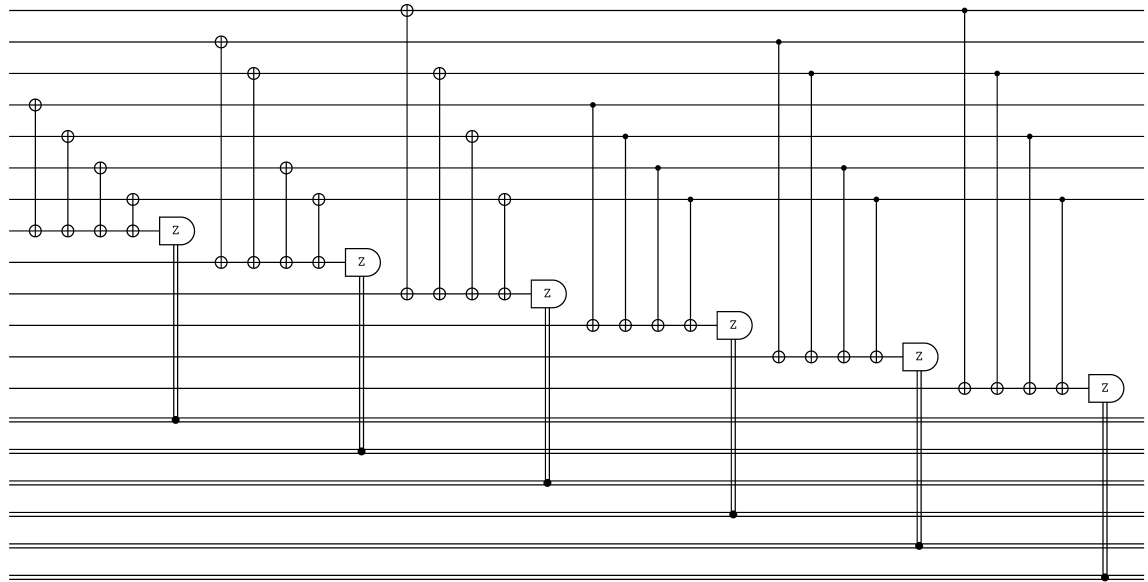

In [346]:
circuit_Z

In [20]:
s, n = size(stab)
_, _, r = canonicalize!(Base.copy(stab), ranks=true)
k = n - r
md = MixedDestabilizer(stab)
logview_Z = logicalzview(md)
logcirc_Z, numLogBits_Z, _ = naive_syndrome_circuit(logview_Z)

(AbstractOperation[sCNOT(2,8), sCNOT(4,8), sCNOT(6,8), sMRZ(8, 1)], 1, 1:1)

In [21]:
noise_circuit_Z = add_two_qubit_gate_noise(circuit_Z, 0.09);

In [22]:
for gate in logcirc_Z
    type = typeof(gate)
    if type == sMRZ
        push!(noise_circuit_Z, sMRZ(gate.qubit+s, gate.bit+s))
    else
        push!(noise_circuit_Z, type(gate.q1, gate.q2+s))
    end
end

In [25]:
errors = [PauliError(i,0.1) for i in 1:7];

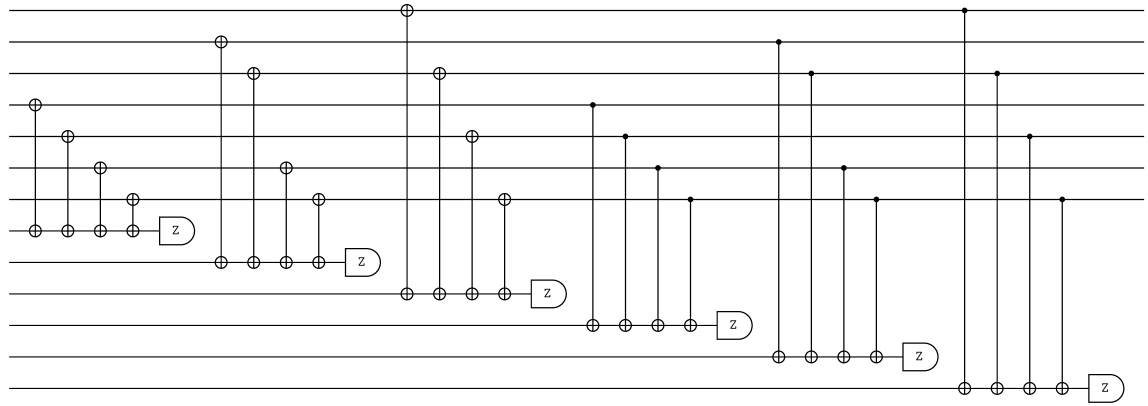

In [23]:
ecirc = fault_tolerant_encoding(circuit_Z)

In [26]:
fullcircuit_Z = vcat(ecirc, errors, noise_circuit_Z)

note: Running TeX ...


┌ Warning: Command failed... ProcessFailedException(Base.Process[Process(`'C:\Users\benku\.julia\artifacts\177ed29d9ff5472967d660c5b817b2c32cdc04af\bin\tectonic.exe' 'C:\Users\benku\AppData\Local\Temp\jl_O7u3jk\input.tex'`, ProcessExited(1))]) Retrying...
└ @ Quantikz C:\Users\benku\.julia\packages\Quantikz\NEGDl\src\Quantikz.jl:40


119-element Vector{AbstractOperation}:
 sXCX(4,8)
 sXCX(5,8)
 sXCX(6,8)
 sXCX(7,8)
 sMZ(8, 0)
 sXCX(2,9)
 sXCX(3,9)
 sXCX(6,9)
 sXCX(7,9)
 sMZ(9, 0)
 ⋮
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [13])
 sCNOT(7,13)
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [7])
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [13])
 sMRZ(13, 6)
 sCNOT(2,14)
 sCNOT(4,14)
 sCNOT(6,14)
 sMRZ(14, 7)

error: input.tex:31: TeX capacity exceeded, sorry [main memory size=5000000]
error: halted on potentially-recoverable error as specified


In [350]:
circuit_Z = add_two_qubit_gate_noise(circuit_Z, 0.09);

AbstractOperation[sXCX(4,8), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03)

, [4]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [8]), sXCX(5,8), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [5]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [8]), sXCX(6,8), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [6]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [8]), sXCX(7,8), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [7]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [8]), sMRZ(8, 1), sXCX(2,9), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [2]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [9]), sXCX(3,9), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [3]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [9]), sXCX(6,9), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [6]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [9]), sXCX(7,9), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [7]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [9]), sMRZ(9, 2), sXCX(1,10), NoiseOp(UnbiasedUncorrelatedNoise{Float

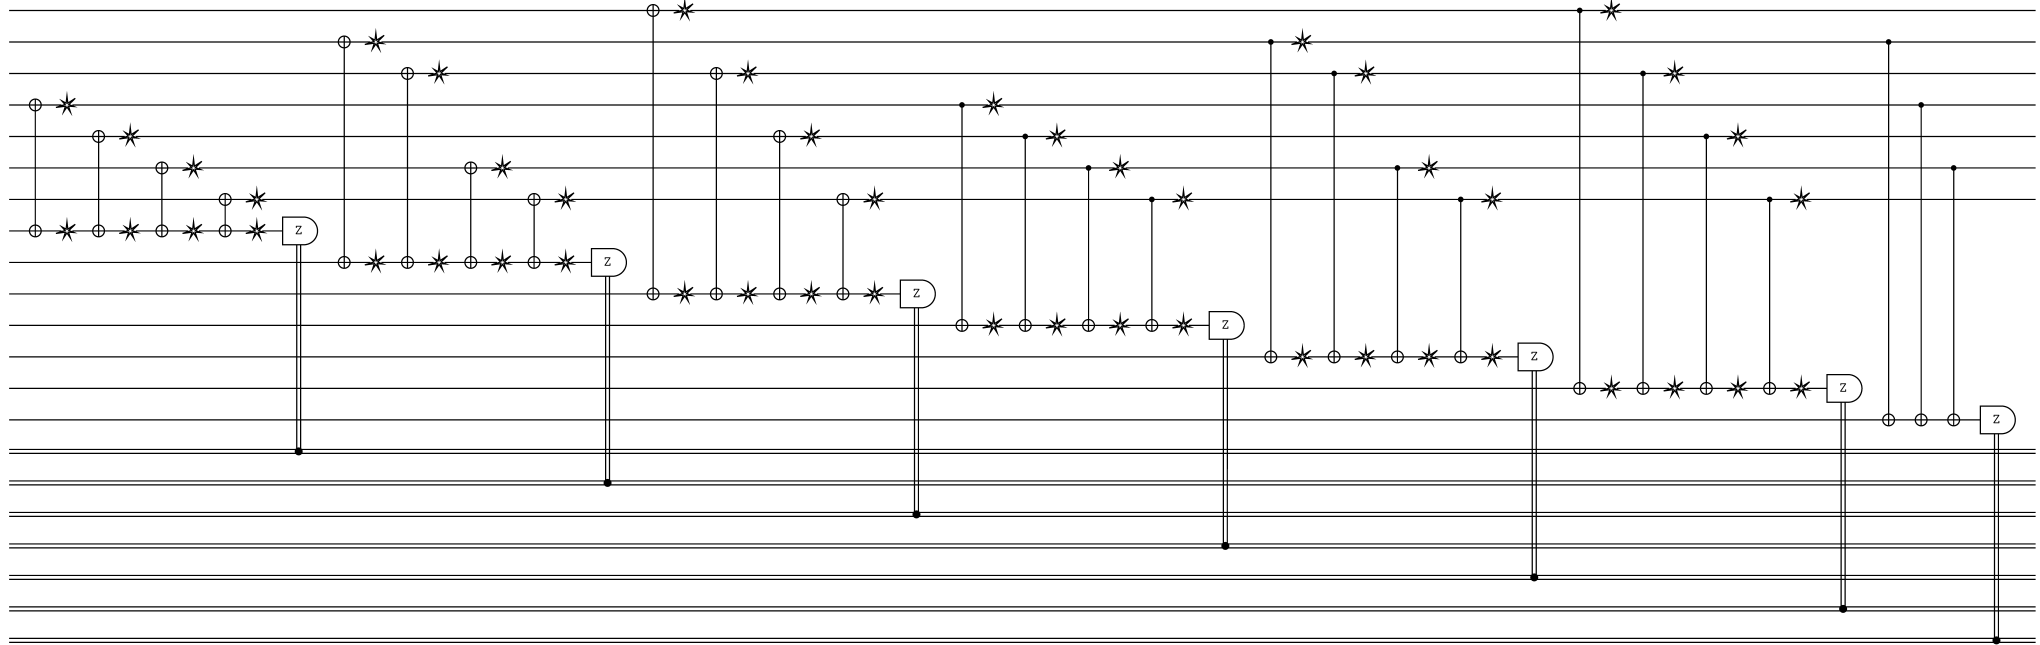

In [18]:
println(circuit_Z)
circuit_Z

In [282]:
errors = [PauliError(i,0.1) for i in 1:7];
println(errors)

NoiseOp[NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03333333333333333), [1]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03333333333333333), [2]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03333333333333333), [3]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03333333333333333), [4]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03333333333333333), [5]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03333333333333333), [6]), NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03333333333333333), [7])]


In [284]:
nframes = 10

10

In [341]:
ecirc_Z = fault_tolerant_encoding(circuit_Z)
fullcircuit_Z = vcat(ecirc_Z, errors, circuit_Z)

frames = PauliFrame(nframes, n+s+k, s+k)
pftrajectories(frames, fullcircuit_Z)

PauliFrame{Stabilizer{QuantumClifford.Tableau{Vector{UInt8}, LinearAlgebra.Adjoint{UInt64, Matrix{UInt64}}}}, Matrix{Bool}}(Stabilizer 10×14, Bool[0 0 … 0 0; 0 0 … 0 1; … ; 0 1 … 0 1; 1 1 … 1 0])

In [342]:
syndromes = pfmeasurements(frames)[:, 1:s]
logicalSyndromes = pfmeasurements(frames)[:, s+1: s+k]
println(syndromes)
println(logicalSyndromes)

Bool[0 0 1 0 0 0; 0 0 0 0 1 0; 0 0 0 0 0 0; 1 0 0 1 1 0; 1 0 0 1 1 1; 1 0 0 0 1 0; 1 0 1 1 0 1; 1 1 0 0 0 1; 0 1 0 1 0 0; 1 1 1 1 1 1]
Bool[0; 1; 1; 1; 0; 1; 1; 1; 1; 0;;]


In [339]:
pre_X = [sHadamard(i) for i in n-k+1:n];

In [340]:
fullcircuit_X = vcat(pre_X, fullcircuit_Z)

note: Running TeX ...


┌ Warning: Command failed... ProcessFailedException(Base.Process[Process(`'C:\Users\benku\.julia\artifacts\177ed29d9ff5472967d660c5b817b2c32cdc04af\bin\tectonic.exe' 'C:\Users\benku\AppData\Local\Temp\jl_Vz8Uyq\input.tex'`, ProcessExited(1))]) Retrying...
└ @ Quantikz C:\Users\benku\.julia\packages\Quantikz\NEGDl\src\Quantikz.jl:40


184-element Vector{AbstractOperation}:
 sHadamard(7)
 sXCX(4,8)
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [4])
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [8])
 sXCX(5,8)
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [5])
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [8])
 sXCX(6,8)
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [6])
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [8])
 ⋮
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [2])
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [14])
 sCNOT(4,14)
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [4])
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [14])
 sCNOT(6,14)
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [6])
 NoiseOp(UnbiasedUncorrelatedNoise{Float64}(0.03), [14])
 sMRZ(14, 7)

error: input.tex:30: TeX capacity exceeded, sorry [main memory size=5000000]
error: halted on potentially-recoverable error as specified


In [9]:
m = [1 2 3; 4 5 6]

2×3 Matrix{Int64}:
 1  2  3
 4  5  6

In [10]:
println(size(m))

(2, 3)


In [33]:
function evaluate_classical_decoder(H, nsamples, init_error, gate_error, syndrome_circuit_func, encoding_circuit_func, pre_circuit = nothing)
    decoded = 0

    H_stab = Stabilizer(fill(0x0, size(H, 2)), H, zeros(Bool, size(H)))

    O = faults_matrix(H_stab)
    syndrome_circuit = syndrome_circuit_func(H_stab)
    
    s, n = size(H)
    k = n - s

    errors = [PauliError(i, init_error) for i in 1:n];

    md = MixedDestabilizer(H_stab)
    
    full_circuit = []

    logview = logicalxview(md)
    logcirc, _ = syndrome_circuit_func(logviews)

    noisy_circuit = add_two_qubit_gate_noise(syndrome_circuit, gate_error);
    
    for gate in logcirc
        type = typeof(gate)
        if type == sMRZ
            push!(circuit, sMRZ(gate.qubit+s, gate.bit+s))
        else
            push!(circuit, type(gate.q1, gate.q2+s))
        end
    end

    ecirc = encoding_circuit_func(scirc)
    if isnothing(pre_circuit)
        full_circuit = vcat(pre_circuits, ecirc, errors, scirc)
    else
        full_circuit = vcat(ecirc, errors, scirc)
    end

    frames = PauliFrame(nframes, n+s+k, s+k)
    pftrajectories(frames, full_circuit)
    syndromes = pfmeasurements(frames)[:, 1:s]
    logical_syndromes = pfmeasurements(frames)[:, s+1: s+k]

    for i in 1:nsamples
        guess = decode(decoder_obj, syndromes[i])

        result = (O * (guess))
        
        if result == logical_syndromes[i]
            decoded += 1
        end
    end

    return (nsamples - decoded) / nsamples
end

evaluate_classical_decoder (generic function with 2 methods)

In [19]:
function evaluate_classical_decoder(decoder_obj::AbstractClassicalSyndromeDecoder, nsamples, init_error, gate_error, encoding_circuit_func, syndrome_circuit_func, pre_circuit = nothing)
    X_syndrome_circuit = syndrome_circuit_func(decoder_obj.Cx)
    Z_syndrome_circuit = syndrome_circuit_func(decoder_obj.Cz)

    n = decoder_obj.n
    s = decoder_obj.s
    k = decpder_obj.k

    errors = [PauliError(i,transmission_error) for i in 1:n];

    md = MixedDestabilizer(checks)
    
    full_circuit = []

    logview = logicalxview(md)
    logcirc, _ = syndrome_circuit_func(logview_X)

    noisy_circuit_X = add_two_qubit_gate_noise(circuit_X, gate_error);
    
    for gate in logcirc_X
        type = typeof(gate)
        if type == sMRZ
            push!(circuit_X, sMRZ(gate.qubit+s, gate.bit+s))
        else
            push!(circuit_X, type(gate.q1, gate.q2+s))
        end
    end

    ecirc = fault_tolerant_encoding(scirc)
    if isnothing(pre_circuit)
        full_circuit = vcat(pre_circuits, ecirc, errors, scirc)
    else
        full_circuit = vcat(ecirc, errors, scirc)
    end

    frames = PauliFrame(nframes, n+s+k, s+k)
    pftrajectories(frames, full_circuit)
    syndromes = pfmeasurements(frames)[:, 1:s]
    logical_syndromes = pfmeasurements(frames)[:, s+1: s+k]

    for i in 1:nsamples
        guess = decode(decoder_obj, X_syndromes[i])

        result = (O * (guess))
        
        if result == logical_syndromes[i]
            X_decoded += 1
        end
        if X_result == Z_logicalSyndromes[i]
            Z_decoded += 1
        end
    end

    X_error = (nsamples - X_decoded) / nsamples
end

UndefVarError: UndefVarError: `AbstractClassicalSyndromeDecoder` not defined

In [25]:
m = Matrix{Bool}([0 0 0 1 1 1 1; 0 1 1 0 0 1 1; 1 0 1 0 1 0 1])

3×7 Matrix{Bool}:
 0  0  0  1  1  1  1
 0  1  1  0  0  1  1
 1  0  1  0  1  0  1

In [34]:
evaluate_classical_decoder(m, 1000, 0.01, 0.0, naive_syndrome_circuit, naive_encoding_circuit)

UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00]


Bool[0 0 0 1 1 1 1; 0 1 1 0 0 1 1; 1 0 1 0 1 0 1]
Bool[0 0 0 0 0 0 0; 0 0 0 0 0 0 0; 0 0 0 0 0 0 0]
+ ___XXXX
+ _XX__XX
+ X_X_X_X


BoundsError: BoundsError: attempt to access 2×3 Matrix{UInt64} at index [1:2, 4]

In [69]:
"""An arbitrary CSS error correcting code defined by its X and Z checks."""
struct CSS <: AbstractECC
    Hx
    Hz
    """Creates a CSS code using the two provided matrices where Hx contains the X checks and Hz contains the Z checks."""
    function CSS(Hx, Hz)
        n = size(Hx, 2)
        if n != size(Hz, 2) error("When constructing a CSS quantum code, the two classical codes are required to have the same block size") end
        if size(Hx,1)+size(Hz,1) >= n error("When constructing a CSS quantum code, the total number of checks (rows) in the parity checks of the two classical codes have to be lower than the block size (the number of columns).") end
        return new(Hx, Hz)
    end
end

function boolean_tableau(c::CSS)
    Hx_height, Hx_width = size(c.Hx)
    Hz_height, Hz_width = size(x.Hz)
    checks_matrix = falses(Hx_height + Hz_height, Hx_width + Hz_width)
    checks_matrix[1:Hx_height, 1:Hx_width] = c.Hx
    checks_matrix[Hx_height+1:end, Hx_width+1:end] = c.Hz
    return CSS(checks_matrix)
end

"""Returns the stabilizer making up the parity check tableau."""
function parity_checks(c::CSS)
    extended_Hx = Matrix{Bool}(vcat(c.Hx, zeros(size(c.Hz))))
    extended_Hz = Matrix{Bool}(vcat(zeros(size(c.Hx)), c.Hz))
    Stabilizer(fill(0x0, size(c.Hx, 2) + size(c.Hz, 2)), extended_Hx, extended_Hz)
end

"""Returns the block length of the code."""
code_n(c::CSS) = size(c.Hx,2)

"""Returns the depth of the parity check matrix"""
code_m(c::CSS) = size(c.Hx, 1) + size(c.Hz, 1)

"""Returns the number of encoded qubits"""
code_k(c::CSS) = (2 * size(c.Hx,2)) - code_m(c)

code_k

In [61]:
abstract type AbstractSyndromeDecoder end

struct TableDecoder <: AbstractSyndromeDecoder
    H
    faults_matrix
    n
    s
    r
    k
    lookup_table
    time 
end

function TableDecoder(Hx, Hz)
    c = CSS(Hx, Hz)
    H = parity_checks(c)
    println(H)
    s, n = size(H)
    _, _, r = canonicalize!(Base.copy(H), ranks=true)
    k = n - r
    lookup_table, time, _ = @timed create_lookup_table(H)
    faults_matrix = faults_matrix(H)
    return TableDecoder(H, n, s, r, k, faults_matrix, lookup_table, time)
end

TableDecoder

In [70]:
TableDecoder(m, m)

+ ___XXXX
+ _XX__XX
+ X_X_X_X
+ ___ZZZZ
+ _ZZ__ZZ
+ Z_Z_Z_Z


BoundsError: BoundsError: attempt to access 2×6 Matrix{UInt64} at index [1:2, 7]